In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns

In [2]:
def convert_seg_error_rate_pct(df):
    df.avg_segment_error_rate = df.avg_segment_error_rate * 100
    return df

In [3]:
HVC_RESULTS_ROOT = pyprojroot.here() / 'results/Bengalese_Finches/hvc'
source_csv = HVC_RESULTS_ROOT / 'segment_error_across_birds.hvc.csv'

In [4]:
hvc_df = pd.read_csv(source_csv)
# make hvc csv column names match the tweetynet column names
# hvc_df.rename(
#      columns={
#          'mean_segment_error_rate': 'avg_segment_error_rate',
#          'train_dur': 'train_set_dur',
#          'replicate': 'replicate_num',
#               },
#     inplace=True)

hvc_df['Segmentation'] = hvc_df['segmentation']
hvc_df['Model'] = 'SVM'

In [5]:
LEARNCURVE_RESULTS_ROOT = pyprojroot.here() / 'results' / 'Bengalese_Finches' / 'learncurve'
error_csv_path = LEARNCURVE_RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
curve_df = pd.read_csv(error_csv_path)

curve_df = curve_df[curve_df.animal_id.isin(hvc_df.animal_id.unique())]
curve_df['Model'] = 'TweetyNet'
curve_df['Segmentation'] = 'None'

In [6]:
CLEANUP = 'min_segment_dur_majority_vote'

curve_df = curve_df[
    curve_df.cleanup == CLEANUP
]

In [7]:
all_df = pd.concat([hvc_df, curve_df])

train_set_durs = sorted(all_df['train_set_dur'].unique())
dur_int_map = dict(zip(train_set_durs, range(len(train_set_durs))))
all_df['train_set_dur_ind'] = all_df['train_set_dur'].map(dur_int_map)

TRAIN_DUR_IND_MAP = {
k:v for k, v in zip(
    sorted(all_df['train_set_dur'].unique()), 
    sorted(all_df['train_set_dur_ind'].unique())
)
}

all_df = convert_seg_error_rate_pct(all_df)

In [8]:
all_df  # sanity check

,Unnamed: 0,animal_id,train_set_dur,replicate_num,segmentation,avg_segment_error_rate,Segmentation,Model,cleanup,avg_acc,avg_levenshtein,avg_pct_boundary_err,model_name,avg_error,train_set_dur_ind
0,0.0,bl26lb16,75,1,manually cleaned,0.391998,manually cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
1,1.0,bl26lb16,75,1,not cleaned,6.504848,not cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
2,2.0,bl26lb16,75,2,manually cleaned,0.334898,manually cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
3,3.0,bl26lb16,75,2,not cleaned,6.331379,not cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
4,4.0,bl26lb16,75,3,manually cleaned,0.325376,manually cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222,NaN,or60yw70,45,6,NaN,2.346490,None,TweetyNet,min_segment_dur_majority_vote,0.976835,1.59375,0.719113,TweetyNet,2.316513,1
2226,NaN,or60yw70,45,7,NaN,2.843207,None,TweetyNet,min_segment_dur_majority_vote,0.977711,1.93750,0.709828,TweetyNet,2.228889,1
2230,NaN,or60yw70,45,8,NaN,4.238627,None,TweetyNet,min_segment_dur_majority_vote,0.969762,2.43750,0.613408,TweetyNet,3.023795,1
2234,NaN,or60yw70,45,9,NaN,2.622161,None,TweetyNet,min_segment_dur_majority_vote,0.977558,1.21875,0.730111,TweetyNet,2.244217,1


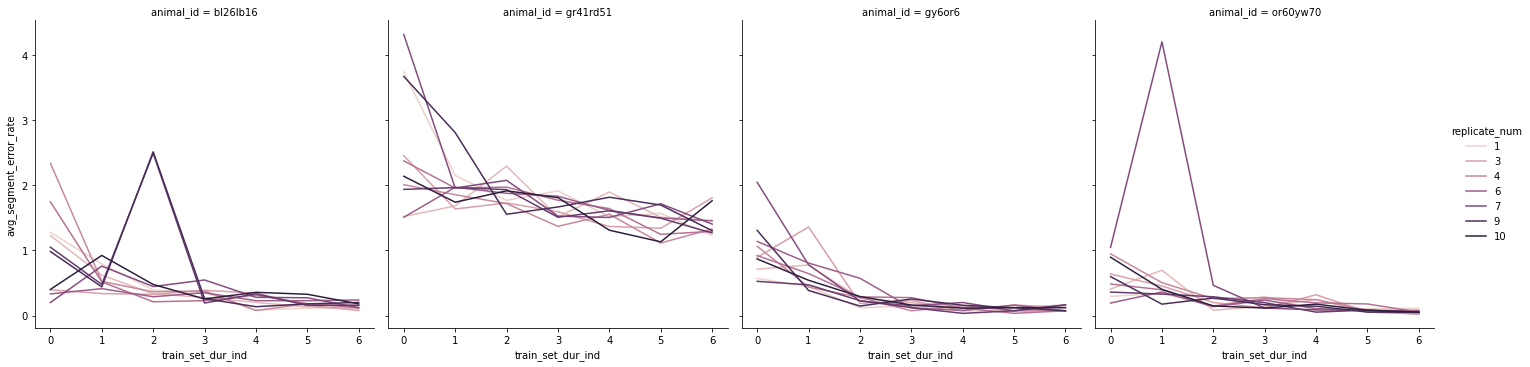

In [9]:
data = all_df[
    (all_df.Model == 'SVM') &
    (all_df.Segmentation == 'manually cleaned')
]
g = sns.relplot(
    data=data,
    x='train_set_dur_ind',
    y='avg_segment_error_rate',
    col='animal_id',
    hue='replicate_num',
    kind='line',
)

# for ax in g.axes.flatten():
#     ax.set_ylim([0., 20.])

In [10]:
gb = all_df.groupby(by=['Model', 'Segmentation', 'animal_id', 'train_set_dur_ind'])
df_agg = gb.agg(
    mean_seg_err = pd.NamedAgg('avg_segment_error_rate', 'mean'),
    median_seg_err = pd.NamedAgg('avg_segment_error_rate', 'median'),
    std_seg_err = pd.NamedAgg('avg_segment_error_rate', 'std')
)

data = df_agg.reset_index()  # ``data`` DataFrame for use with ``seaborn``

In [11]:
data

,Model,Segmentation,animal_id,train_set_dur_ind,mean_seg_err,median_seg_err,std_seg_err
0,SVM,manually cleaned,bl26lb16,0,0.995317,1.016175,0.690081
1,SVM,manually cleaned,bl26lb16,1,0.580945,0.520793,0.188465
2,SVM,manually cleaned,bl26lb16,2,0.784862,0.378334,0.908652
3,SVM,manually cleaned,bl26lb16,3,0.323614,0.314727,0.102842
4,SVM,manually cleaned,bl26lb16,4,0.236407,0.254926,0.107391
...,...,...,...,...,...,...,...
79,TweetyNet,None,or60yw70,2,1.987739,1.859268,0.365612
80,TweetyNet,None,or60yw70,3,1.948564,1.855069,0.485927
81,TweetyNet,None,or60yw70,4,1.709439,1.655702,0.334621
82,TweetyNet,None,or60yw70,5,0.909602,0.944231,0.219307


In [12]:
FIG_ROOT = pyprojroot.here() / 'doc' / 'article' / 'figures' / 'mainfig_tweetynet_v_svm'
FIG_ROOT.mkdir(exist_ok=True)

In [13]:
MODEL_HUE_MAP = {
    'SVM': 'blue',
    'TweetyNet': 'lawngreen',
}

In [14]:
svm_mean_seg_err_max_dur = data[
    (data.Model=='SVM') & (data.Segmentation == 'manually cleaned') & (data.train_set_dur_ind ==  6)
].mean_seg_err.mean()

tweetynet_mean_seg_err_max_dur = data[
    (data.Model=='TweetyNet') & (data.Segmentation == 'None') & (data.train_set_dur_ind ==  6)
].mean_seg_err.mean()

<ipython-input-15-85c88325b5cc>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(train_set_durs, rotation=45)


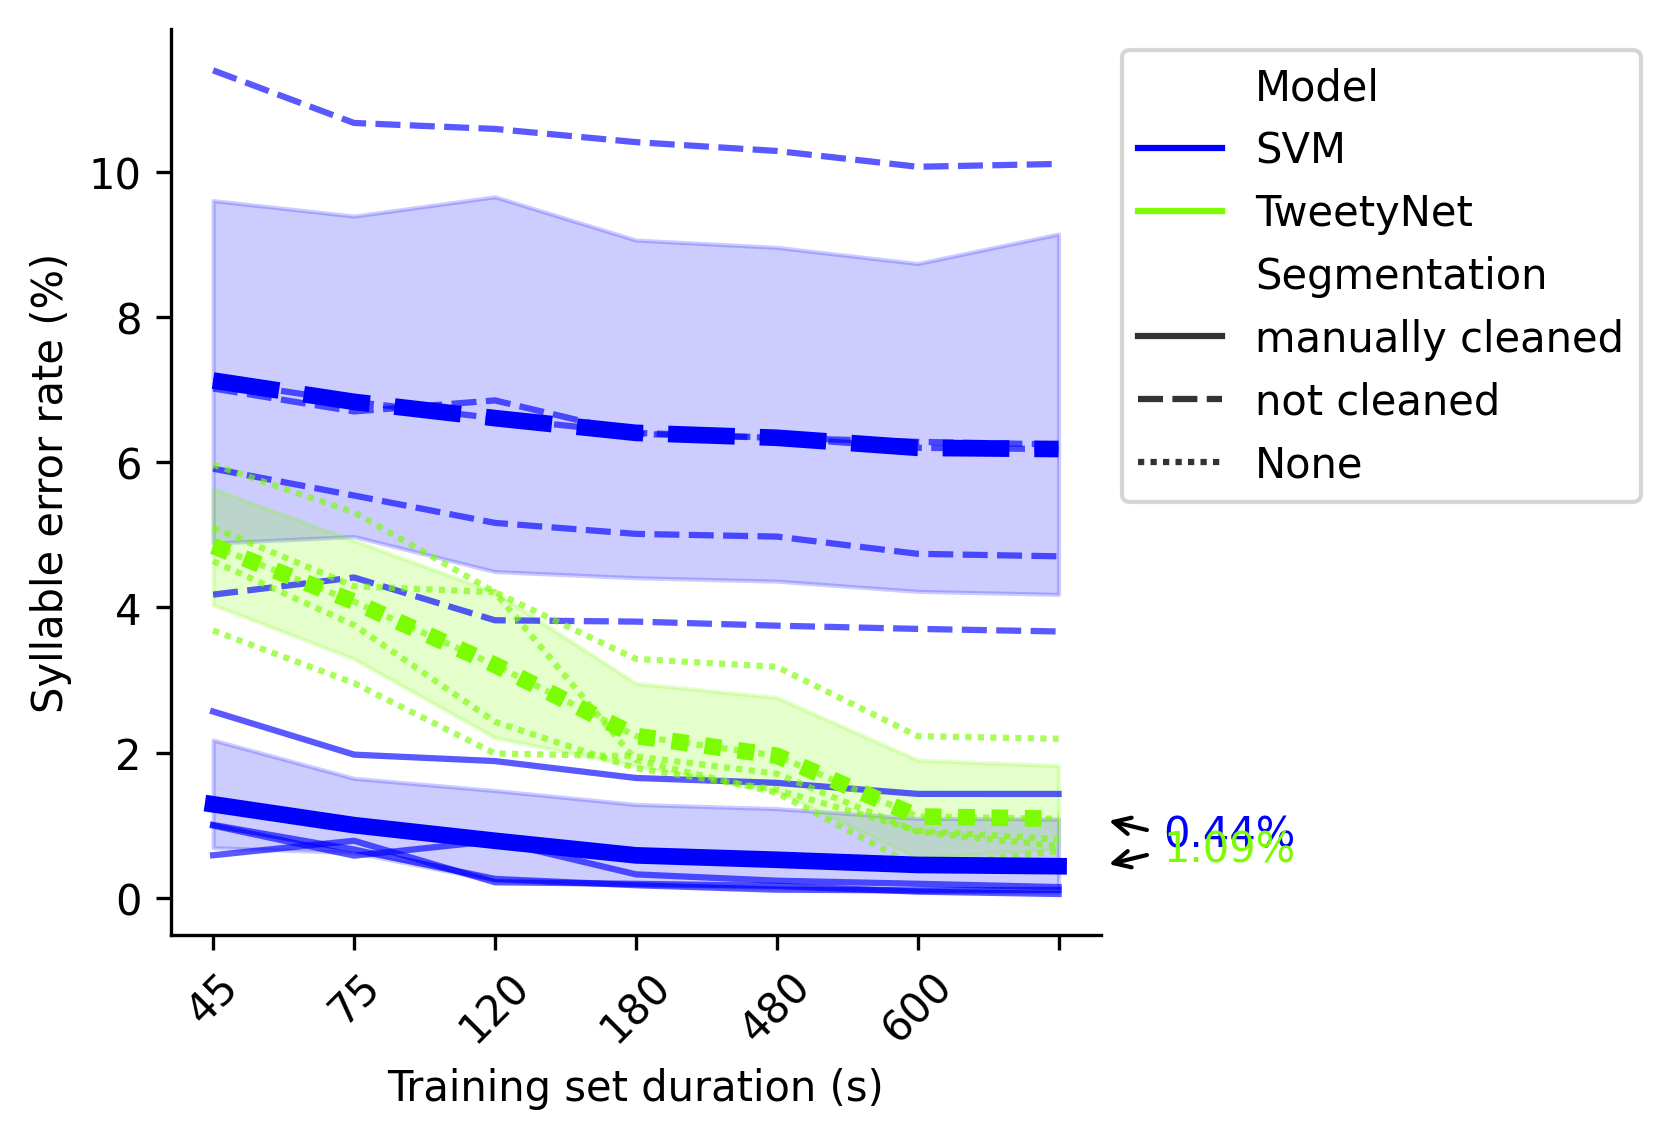

In [15]:
fig, ax = plt.subplots()
fig.set_dpi(300)
fig.set_size_inches(4,4)

sns.lineplot(
    data=data,
    x='train_set_dur_ind',
    y='mean_seg_err',
    hue='Model',
    palette=MODEL_HUE_MAP,
    style='Segmentation',
    units='animal_id',
    estimator=None,
    alpha=0.65,
    ax=ax,
    legend=False,
)


sns.lineplot(
    data=data,
    x='train_set_dur_ind',
    y='mean_seg_err',
    hue='Model',
    palette=MODEL_HUE_MAP,
    style='Segmentation',
    alpha=0.65,
    ax=ax,
    legend=True,
)

g = sns.lineplot(x='train_set_dur_ind',
             y='mean_seg_err',
             linewidth=4,
             style='Segmentation',
             hue='Model',
             palette=MODEL_HUE_MAP,
             data=data, 
             ci=None,
             ax=ax,
             legend=False)
g.legend(loc='upper left', bbox_to_anchor=[1.0, 1.0])

ax.set_xticklabels(train_set_durs, rotation=45)

ax.annotate(f'{svm_mean_seg_err_max_dur:0.2f}%',
            xy=(ax.get_xlim()[-1], svm_mean_seg_err_max_dur), 
            xycoords='data',
            xytext=(15, +7.5),
            textcoords='offset points',
            verticalalignment='center',
            color=MODEL_HUE_MAP['SVM'],
            arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['SVM']),
            annotation_clip=False)

ax.annotate(f'{tweetynet_mean_seg_err_max_dur:0.2f}%',
            xy=(ax.get_xlim()[-1], tweetynet_mean_seg_err_max_dur), 
            xycoords='data',
            xytext=(15, -7.5),
            textcoords='offset points',
            verticalalignment='center',
            color=MODEL_HUE_MAP['TweetyNet'],
            arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['TweetyNet']),
            annotation_clip=False)

ax.set_xlabel('Training set duration (s)')
ax.set_ylabel('Syllable error rate (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

FIG_STEM = 'svm-v-tweetynet-results'
    
# for ext in ('png', 'svg'):
#     fig.savefig(FIG_ROOT / f'{FIG_STEM}.{ext}');

<ipython-input-17-40e72facfd86>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(train_set_durs, rotation=45)


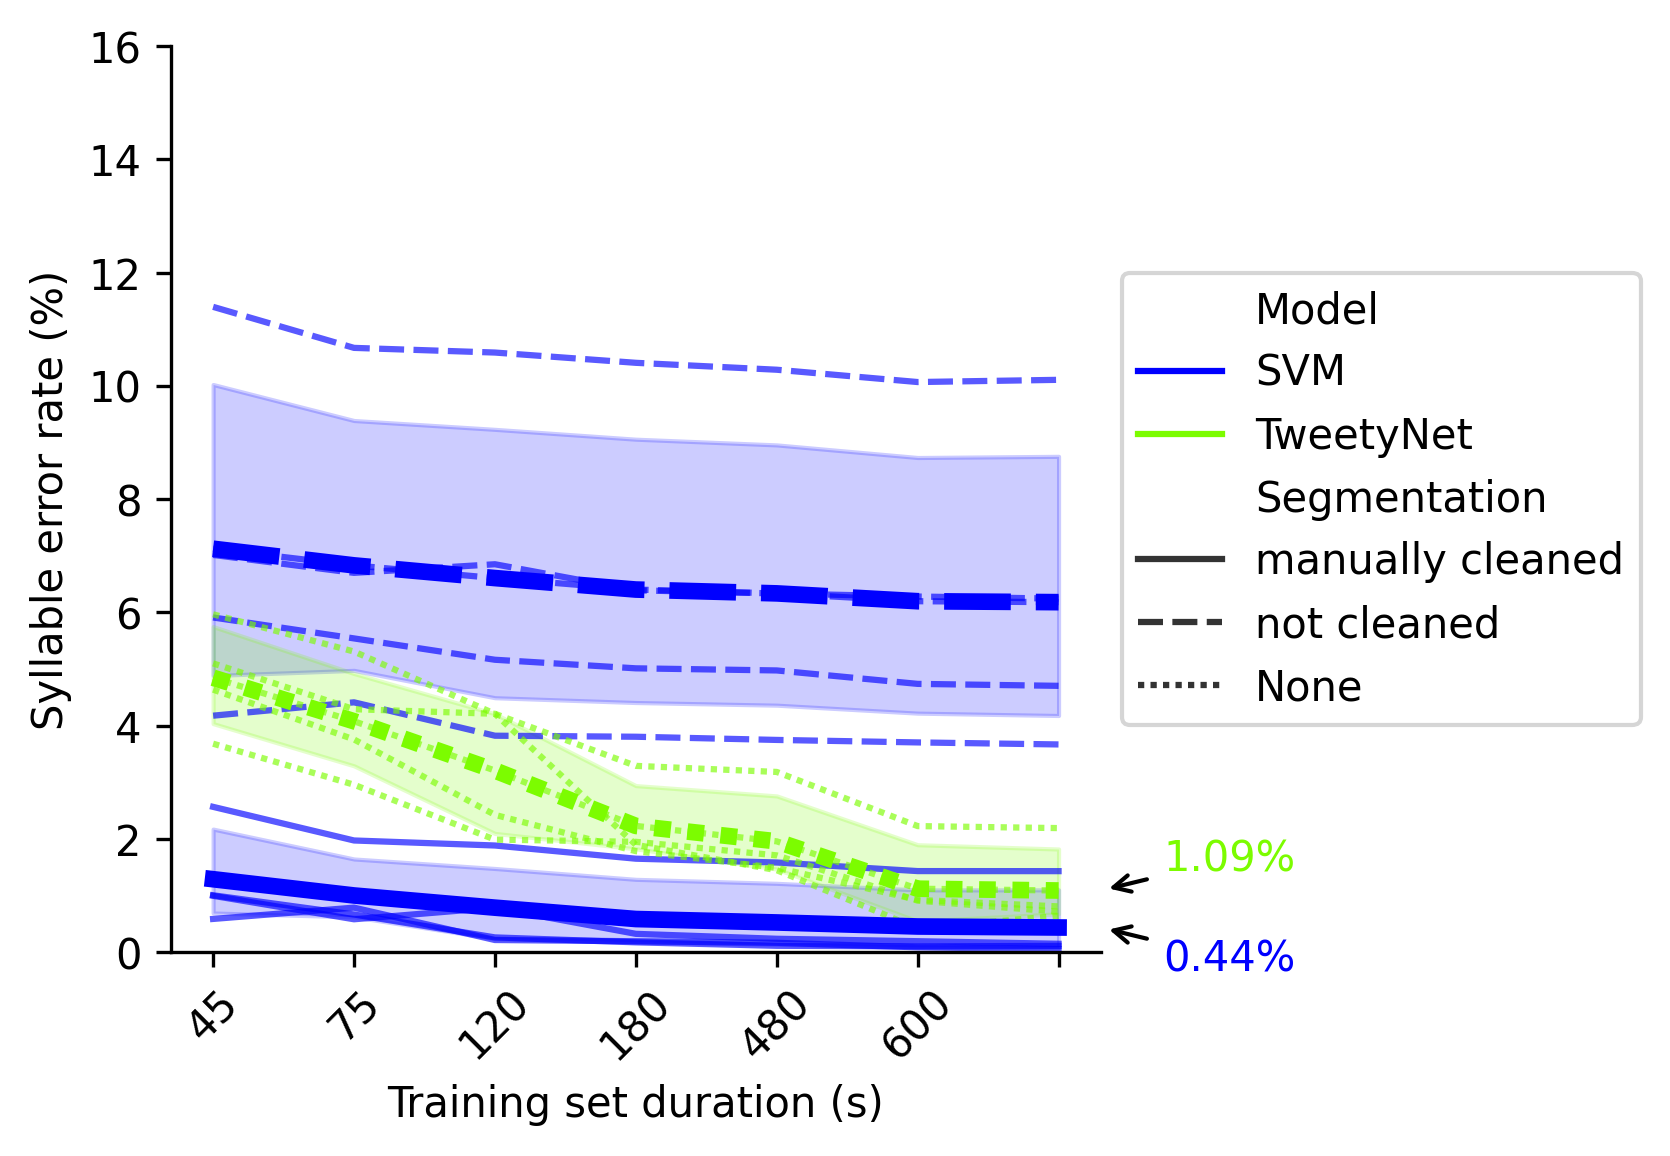

In [17]:
fig, ax = plt.subplots()
fig.set_dpi(300)
fig.set_size_inches(4,4)

sns.lineplot(
    data=data,
    x='train_set_dur_ind',
    y='mean_seg_err',
    hue='Model',
    palette=MODEL_HUE_MAP,
    style='Segmentation',
    units='animal_id',
    estimator=None,
    alpha=0.65,
    ax=ax,
    legend=False,
)


sns.lineplot(
    data=data,
    x='train_set_dur_ind',
    y='mean_seg_err',
    hue='Model',
    palette=MODEL_HUE_MAP,
    style='Segmentation',
    alpha=0.65,
    ax=ax,
    legend=True,
)

g = sns.lineplot(x='train_set_dur_ind',
             y='mean_seg_err',
             linewidth=4,
             style='Segmentation',
             hue='Model',
             palette=MODEL_HUE_MAP,
             data=data, 
             ci=None,
             ax=ax,
             legend=False)
g.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])

ax.set_xticklabels(train_set_durs, rotation=45)

ax.annotate(f'{svm_mean_seg_err_max_dur:0.2f}%',
            xy=(ax.get_xlim()[-1], svm_mean_seg_err_max_dur), 
            xycoords='data',
            xytext=(15, -7.5),
            textcoords='offset points',
            verticalalignment='center',
            color=MODEL_HUE_MAP['SVM'],
            arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['SVM']),
            annotation_clip=False)

ax.annotate(f'{tweetynet_mean_seg_err_max_dur:0.2f}%',
            xy=(ax.get_xlim()[-1], tweetynet_mean_seg_err_max_dur), 
            xycoords='data',
            xytext=(15, +7.5),
            textcoords='offset points',
            verticalalignment='center',
            color=MODEL_HUE_MAP['TweetyNet'],
            arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['TweetyNet']),
            annotation_clip=False)

ax.set_ylim([0., 16.])

ax.set_xlabel('Training set duration (s)')
ax.set_ylabel('Syllable error rate (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

FIG_STEM = 'svm-v-tweetynet-results'
    
for ext in ('png', 'svg'):
    fig.savefig(FIG_ROOT / f'{FIG_STEM}.{ext}');

<ipython-input-24-0ff385535511>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_arr[1].set_xticklabels(train_set_durs, rotation=45)


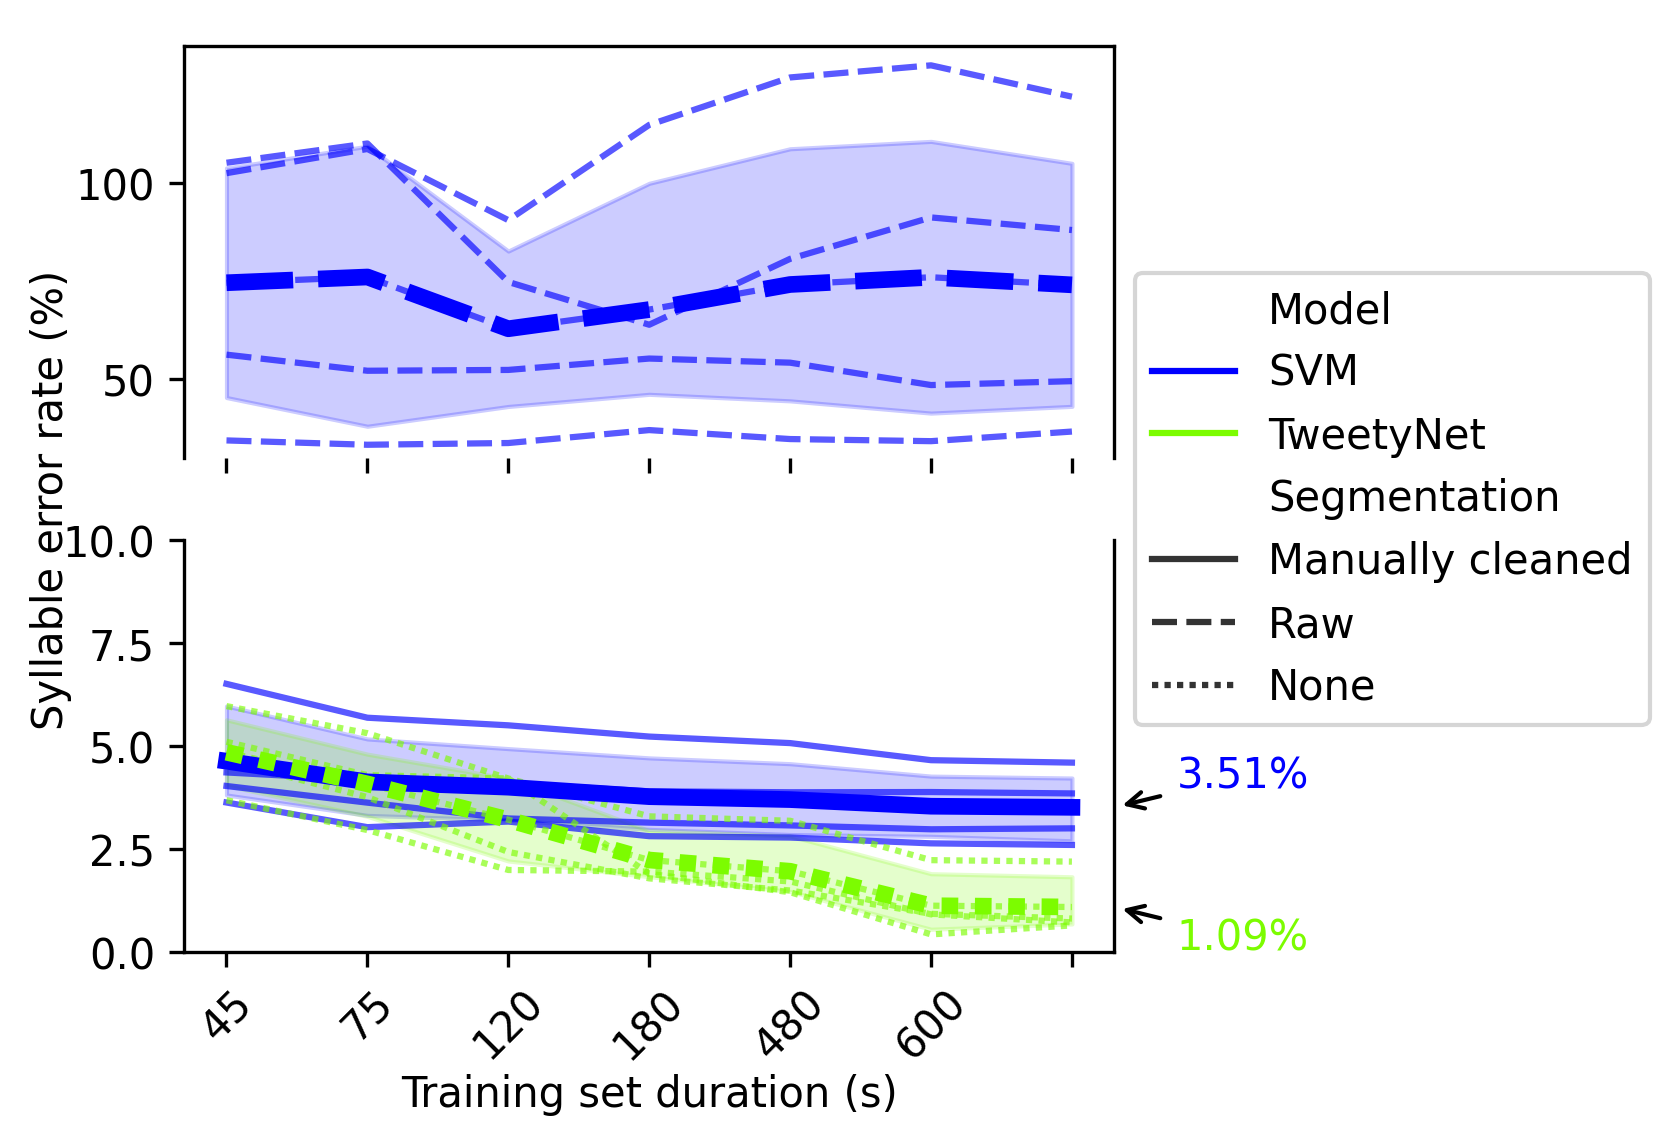

In [24]:
dpi = 300
figsize = (4,4)
fig = plt.figure(constrained_layout=False, figsize=figsize, dpi=dpi)

gs = fig.add_gridspec(nrows=2, ncols=1)

ax_arr = []
ax_arr.append(fig.add_subplot(gs[0, 0]))
ax_arr.append(fig.add_subplot(gs[1, 0]))

ax_arr = np.asarray(ax_arr)
ax_arr[0].get_shared_x_axes().join(ax_arr[1])

ax_arr[0].spines['bottom'].set_visible(False)
ax_arr[1].spines['top'].set_visible(False)
ax_arr[1].xaxis.tick_bottom()

for ax_num, ax in enumerate(ax_arr):
    if ax_num == 1:
        legend = True
    else:
        legend = False

    sns.lineplot(
        data=data,
        x='train_set_dur_ind',
        y='mean_seg_err',
        hue='Model',
        palette=MODEL_HUE_MAP,
        style='Segmentation',
        units='animal_id',
        estimator=None,
        alpha=0.65,
        ax=ax,
        legend=False,
    )

    sns.lineplot(
        data=data,
        x='train_set_dur_ind',
        y='mean_seg_err',
        hue='Model',
        palette=MODEL_HUE_MAP,
        style='Segmentation',
        alpha=0.65,
        ax=ax,
        legend=legend,
    )

    g = sns.lineplot(x='train_set_dur_ind',
                 y='mean_seg_err',
                 linewidth=4,
                 style='Segmentation',
                 hue='Model',
                 palette=MODEL_HUE_MAP,
                 data=data, 
                 ci=None,
                 ax=ax,
                 legend=False)
    
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        g.legend_.remove()
    
    ax.set_ylabel('')
    ax.set_xlabel('')

ax_arr[1].set_xticklabels(train_set_durs, rotation=45)

ax_arr[1].annotate(f'{svm_mean_seg_err_max_dur:0.2f}%',
            xy=(ax.get_xlim()[-1], svm_mean_seg_err_max_dur), 
            xycoords='data',
            xytext=(15, +7.5),
            textcoords='offset points',
            verticalalignment='center',
            color=MODEL_HUE_MAP['SVM'],
            arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['SVM']),
            annotation_clip=False)

ax_arr[1].annotate(f'{tweetynet_mean_seg_err_max_dur:0.2f}%',
            xy=(ax.get_xlim()[-1], tweetynet_mean_seg_err_max_dur), 
            xycoords='data',
            xytext=(15, -7.5),
            textcoords='offset points',
            verticalalignment='center',
            color=MODEL_HUE_MAP['TweetyNet'],
            arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['TweetyNet']),
            annotation_clip=False)

ax_arr[0].set_xticklabels([])

ax_arr[0].set_ylim([30., 135.])
ax_arr[1].set_ylim([0., 10.])

# ax.set_xlabel('Training set duration (s)')
# ax.set_ylabel('Syllable error rate (%)')

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

bigax = fig.add_subplot(111, frameon=False)
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bigax.grid(False)
bigax.set_xlabel('Training set duration (s)', labelpad=12)
bigax.set_ylabel('Syllable error rate (%)')


bigax.legend(handles, labels, loc='center left', bbox_to_anchor=[1.0, 0.5])

FIG_STEM = 'svm-v-tweetynet-results'
    
for ext in ('png', 'svg'):
    fig.savefig(FIG_ROOT / f'{FIG_STEM}.{ext}');